In [1]:
import numpy as np
import cv2
import glob
import os
import time
from templates import TEMPLATES
from annotator import MatplotlibAnnotator
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [2]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import Image,display

In [3]:
%gui tk
%matplotlib notebook

In [4]:
# Create widgets
directory = widgets.Dropdown(options=TEMPLATES.keys())
images = widgets.Dropdown(options=os.listdir('data/'+directory.value))
input_variable=widgets.Text()
input_exention=widgets.Text()

tempate_variable=widgets.Text()

# Updates the image options based on directory value
def update_images(*args):
    images.options = sorted(os.listdir('data/'+directory.value))

# Tie the image options to directory value
directory.observe(update_images, 'value')

img_ext = ['.gif', '.jpg', '.jpeg']
vid_ext=['.mp4', '.avi']

# Show the images
def select_image(template, file):
    tempate_variable.value=template
    _,extention=os.path.splitext(file)
    input_exention.value=extention
    if extention in img_ext:
        display(Image('data/'+template+'/'+file))
    input_variable.value='data/'+template+'/'+file
    return

_ = interact(select_image, template=directory, file=images)

interactive(children=(Dropdown(description='template', options=('baseball', 'basketball'), value='baseball'), …

In [5]:
input_path=input_variable.value
input_type=input_exention.value
curr_template=tempate_variable.value
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

In [6]:
import matplotlib.animation as animation

def extract_images(video,fps=None):
    cap = cv2.VideoCapture(video)
    if fps is None:
        fps_vd = cap.get(cv2.CAP_PROP_FPS) 
    else:
        fps_vd=fps
        cap.set(cv2.CAP_PROP_FPS, fps_vd)
            
    ims_cv=[]

    while True:
        ret, frame = cap.read()
        if not ret:
            cap.release()
            cv2.destroyWindow('Video')
            break
            
        ims_cv.append(frame)        
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                
        cv2.imshow('Video',frame)
        if cv2.waitKey(100) & 0xFF == ord('q'):
            break

    return fps_vd, ims_cv

In [7]:
if input_type in vid_ext:
    fps,images=extract_images(input_path)
    print(fps)
else:
    images=[cv2.imread(input_path)]

In [8]:
len(images)

1

In [9]:
list(TEMPLATES[curr_template].keys())

['home_plate',
 'left_batters',
 'right_batters',
 'pitchers_mound_center',
 'pitchers_mound_left',
 'first_base',
 'second_base',
 'third_base']

In [10]:
x = MatplotlibAnnotator()
obj_list=TEMPLATES[curr_template].keys()
checkboxs_dict={}
# obj_dict={}
for p in obj_list:
    chkbox=widgets.Checkbox(
        value=False,
        description=p,
        disabled=False
    )
    checkboxs_dict[p]=chkbox
#     obj_dict[p]=widgets.widget_bool()
checkboxs_list=list(checkboxs_dict.values())
checkboxs_Vboxs=widgets.VBox([box for box in checkboxs_list])

In [11]:
display(checkboxs_Vboxs)

In [12]:
obj_keys=[name for name in checkboxs_dict if checkboxs_dict[name].value ]
obj_keys

['home_plate', 'left_batters', 'right_batters', 'pitchers_mound_center']

<IPython.core.display.Javascript object>


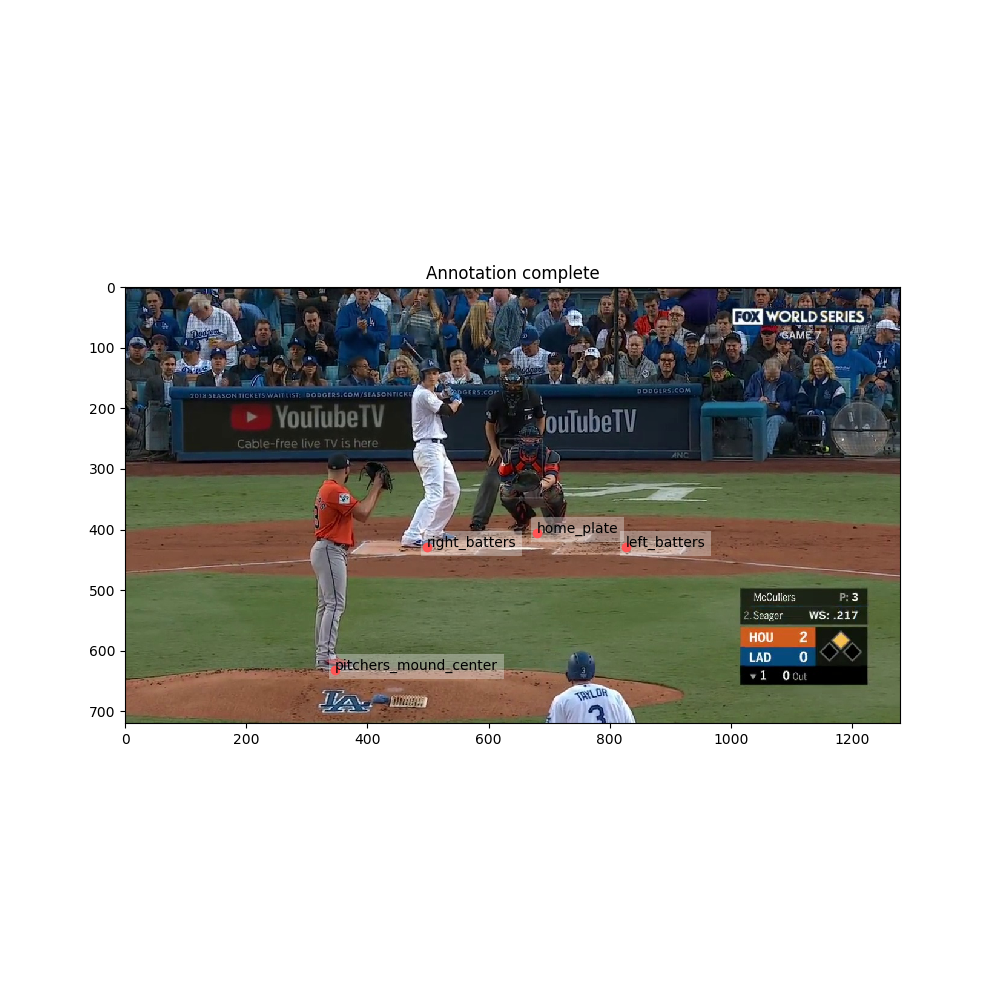

In [14]:
if curr_template=="baseball":
    x.plot_annotate(cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB),obj_keys)
    img_keys=x.get_annotations()

In [15]:
def matchObjImg(obj_keys,imgp,nframes=1):
    if len(obj_keys)<3:
        print("Invalid calibration!")
        return
    objpoints = [] # 3d point in real world space
    imgpoints = [] # 2d points in image plane.
    for key in obj_keys:
        objpoints.append(TEMPLATES[curr_template][key])
        imgpoints.append(imgp[key])
    objpoints=objpoints*nframes
    imgpoints=imgpoints*nframes
    objpoints=np.array(objpoints).reshape(nframes,-1,3).astype('float32')
    imgpoints=np.array(imgpoints).reshape(nframes,-1,2).astype('float32')
    return objpoints,imgpoints

In [21]:
def calibration(img,objpoints,imgpoints):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
    # mtx: intrinsix matrix,dist:distortion coefficeint, rvecs: rotation, tvecs: translation
    
    h,  w = img.shape[:2]
    
    newcameramtx, roi=cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h)) # new intrinsic matrix
    dst = cv2.undistort(img, mtx, dist, None, newcameramtx)

    # crop the image
    x,y,w,h = roi
    dst = dst[y:y+h, x:x+w]
    cv2.imshow('output',dst) 
    cv2.waitKey(2000)

    cv2.destroyAllWindows()
    return mtx,dist,rvecs,tvecs

In [22]:
if curr_template=="baseball":
    objpoints,imgpoints=matchObjImg(obj_keys,img_keys,nframes=len(images))
    mtx,dist,rvecs,tvecs=calibration(images[0],objpoints,imgpoints)

In [46]:
def drawProjection(matrix,objpoints,imgpoints,img):
    mtx,dist,rvecs,tvecs=matrix
    plt.imshow(img,cmap='gray', vmin=0, vmax=255)
    imgpoints2, _ = cv2.projectPoints(objpoints, rvecs[0], tvecs[0], mtx, dist)
    imgpoints2=np.array(imgpoints2).reshape(-1,2)
    error = cv2.norm(imgpoints,imgpoints2, cv2.NORM_L2)/len(imgpoints2)
    for imgp,imgp2 in zip(imgpoints,imgpoints2.tolist()):
        ox,oy=imgp
        px,py=imgp2
        plt.scatter(x=ox, y=oy, c='r', s=10)  # original:red
        plt.scatter(x=px, y=py, c='y', s=10)  # calibration:yellow
    plt.show()
    return error

In [39]:
objpoints[0].shape

(4, 3)

<IPython.core.display.Javascript object>


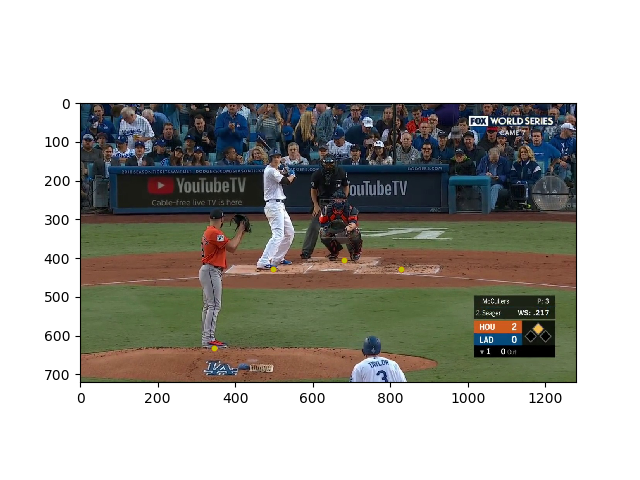

0.0


In [47]:
matrix=mtx,dist,rvecs,tvecs
img=cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB)
plt.imshow(img)
error=drawProjection(matrix,objpoints[0],imgpoints[0],img)
print(error)